In [ ]:
import pandas as pd
import json
import re
import numpy as np
from pathlib import Path
from tqdm import tqdm

In [ ]:
base_folder = Path("data")
df_pred = pd.read_parquet(base_folder / f"research_paper_data_{MODEL_NAME_STR}_{NUMBER_OF_PATTERNS}.parquet")

In [193]:
list_knowledge = []
list_knowledge_difficult = []
for i in tqdm(range(df_pred.shape[0])):
    uuid = df_pred['uuid'].iloc[i]
    published = df_pred['published'].iloc[i]

    # get legit patterns
    predicted_json = df_pred['double_check_patterns'].iloc[i]
    list_patterns = re.findall(r'"pattern(\d+)"', predicted_json)

    # get legit elements
    predicted_json = df_pred['ungc_patterns'].iloc[i]
    try:
        predicted_pattern_text = json.loads(predicted_json)['patterns']
    except:
        try:
            predicted_json_fixed = re.sub(r'(?<=, )([a-zA-Z][^"\[\]{},:\n]+)(?=,|\]|\s*")', r'"\1"', predicted_json).replace('""', '"')
            predicted_pattern_text = json.loads(predicted_json_fixed)['patterns']
        except:
            try:
                predicted_json_fixed = predicted_json.replace("]]","]").replace(']\n        }',"]]\n}")
                predicted_pattern_text = json.loads(predicted_json_fixed)['patterns']
                list_knowledge_difficult.append([uuid, published, predicted_json, predicted_pattern_text])
            except:
                print(f"Error processing JSON for uuid {uuid}")
                continue
    for pattern in predicted_pattern_text:
        for legit_pattern in list_patterns:
            if pattern != "patterns":
                if f"pattern{legit_pattern}" in list(pattern.keys()):
                    for knowledge in pattern[f"pattern{legit_pattern}"]:
                        list_knowledge.append([uuid, published, int(legit_pattern)] + knowledge)

100%|██████████| 2062/2062 [00:00<00:00, 30733.40it/s]


In [194]:
all_knowledge = pd.DataFrame(list_knowledge, columns = ['uuid','date','pattern', 'S', 'V', 'O'])
all_knowledge.shape

(1196, 6)

In [198]:
from collections import defaultdict
class EntityDict:
    def __init__(self, category, data):
        self.entity_ids = {}
        self.category = category
        self.occurrences = defaultdict(int)
        self.data = data

    def get_new_id(self) -> int:
        return max(self.entity_ids.values(), default=-1) + 1

    def get_id(self, name: str) -> int:
        return self.entity_ids.get(name)

    def store_id(self, name: str, id: int) -> None:
        self.entity_ids[name] = id

    def check_if_exists(self, names: list) -> int:
        for name in names:
            if name in self.entity_ids:
                return self.entity_ids[name]
        return None

    def generate_dict(self):
        for _, row in self.data.iterrows():
            entities = json.loads(row['json_entities']).get(self.category, [])
            for ent in entities:
                if len(ent) > 3:
                    for sub_ent in ent:
                        found_id = self.check_if_exists([sub_ent])
                        self.store_id(sub_ent, found_id or self.get_new_id())
                else:
                    found_id = self.check_if_exists(ent)
                    new_id = found_id or self.get_new_id()
                    for name in ent:
                        self.store_id(name, new_id)
        self.entity_ids = dict(sorted(self.entity_ids.items(), key=lambda x: x[1]))

    def generate_occurences(self):
        self.occurrences = defaultdict(int)
        for _, row in self.data.iterrows():
            entities = json.loads(row['json_entities']).get(self.category, [])
            for ent in entities:
                if isinstance(ent, list) and ent:
                    self.occurrences[ent[0]] += 1
                elif isinstance(ent, str) and len(ent) > 2:
                    self.occurrences[ent] += 1
        self.occurrences = dict(sorted(self.occurrences.items(), key=lambda x: x[1], reverse=True))

    def generate_events(self, entity_name):
        events = {
            row['title']: row['published'][0:10]
            for _, row in self.data.iterrows()
            for ent in json.loads(row['json_entities']).get(self.category, [])
            if ((isinstance(ent, list) and ent and ent[0] == entity_name) or
                (isinstance(ent, str) and len(ent) > 2 and ent == entity_name))
        }
        return sorted(events.items(), key=lambda x: x[1])

    def get_id_and_names(self, name):
        try:
            name_id = self.entity_ids[name]
        except KeyError:
            return None, []
        result = [key for key, val in self.entity_ids.items() if val == name_id]
        return name_id, result
org_dict = EntityDict('ORG', df_pred)
org_dict.generate_dict()
org_dict.generate_occurences()
list_ids = []
for key in org_dict.entity_ids.keys():
    list_ids.append(org_dict.entity_ids[key])
list_ids = np.unique(list_ids).tolist()
# search names from id in org_dict.entity_ids
def search_names_from_id(entity_dict, entity_id):
    return [name for name, id in entity_dict.entity_ids.items() if id == entity_id]


In [204]:
for i in tqdm(range(all_knowledge.shape[0])):
    entity_name = all_knowledge['S'].iloc[i]
    for id_ in list_ids:
        list_names = search_names_from_id(org_dict, id_)
        if entity_name in list_names:
            all_knowledge.at[i, 'entity_id'] = id_
            all_knowledge.at[i, 'entity_names'] = list_names
            break


100%|██████████| 1196/1196 [04:18<00:00,  4.62it/s]


In [228]:
all_knowledge.to_csv('all_knowledge.csv', index=False)

In [249]:
all_knowledge = pd.read_csv('all_knowledge.csv')
all_knowledge['UNGC'] = [(int(i)-1)//3+1 for i in all_knowledge['pattern']]

In [278]:
edges_all = pd.DataFrame()
for entity_id in all_knowledge['entity_id'].dropna().unique():
    knowledge = all_knowledge[all_knowledge['entity_id'] == entity_id]
    knowledge['yyyymmdd'] = [date.strftime('%Y%m%d') for date in pd.to_datetime(knowledge['date'])]
    knowledge.sort_values(by='yyyymmdd', inplace=True)
    list_yyyymmdd = knowledge['yyyymmdd'].dropna().unique().tolist()

    for j in range(len(list_yyyymmdd)-1):
        b_yyyymmdd, a_yyyymmdd = list_yyyymmdd[j], list_yyyymmdd[j+1]
        b_list_UNGC, a_list_UNGC = knowledge[knowledge['yyyymmdd'] == b_yyyymmdd]['UNGC'].unique().tolist(), knowledge[knowledge['yyyymmdd'] == a_yyyymmdd]['UNGC'].unique().tolist()

        # make list of pairs, directional in time
        pairs = [(a, b) for a in b_list_UNGC for b in a_list_UNGC]

        edges = pd.DataFrame(pairs, columns = ['from', 'to'])
        edges['yyyymmdd_from'] = b_yyyymmdd
        edges['yyyymmdd_to'] = a_yyyymmdd
        edges.index = [int(entity_id)]*edges.shape[0]
        edges.index.name = 'entity_id'
        edges_all = pd.concat([edges_all, edges], axis = 0)

C:\Users\TsuyoshiIwata\AppData\Local\Temp\ipykernel_14936\1508319412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knowledge['yyyymmdd'] = [date.strftime('%Y%m%d') for date in pd.to_datetime(knowledge['date'])]
C:\Users\TsuyoshiIwata\AppData\Local\Temp\ipykernel_14936\1508319412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knowledge.sort_values(by='yyyymmdd', inplace=True)
C:\Users\TsuyoshiIwata\AppData\Local\Temp\ipykernel_14936\1508319412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [279]:
print(edges_all.shape)

(181, 4)


In [280]:
transition_matrix = pd.DataFrame(0, index=range(1,11), columns=range(1,11))
for a, b in zip(edges_all['from'], edges_all['to']):
    transition_matrix.at[a, b] += 1

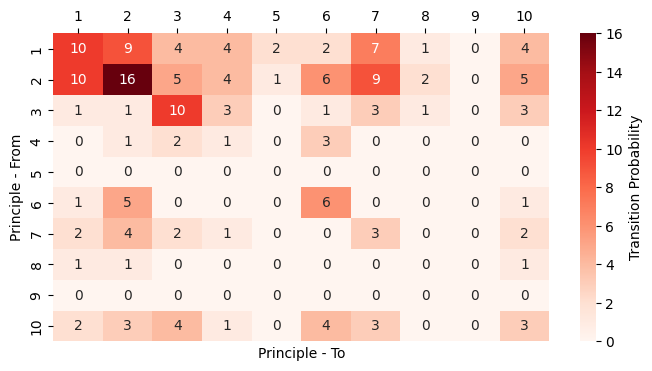

In [ ]:
# make heatmap of transition matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Transition Count'})
# plt.title('UNGC Infringement Transition Matrix')
# xlabel on top
plt.xlabel('Principle - To')
plt.gca().xaxis.set_ticks_position('top')
plt.ylabel('Principle - From')
plt.savefig('transition_matrix_conditioned_with_news_in_multipledates.png', dpi=300)
plt.show()


In [293]:
list_samplesize = [edges_all[edges_all['from']==i].reset_index()[['entity_id','yyyymmdd_from']].drop_duplicates().shape[0] for i in range(1,11)]
list_samplesize = [i if i > 0 else 1 for i in list_samplesize]  # avoid division by zero

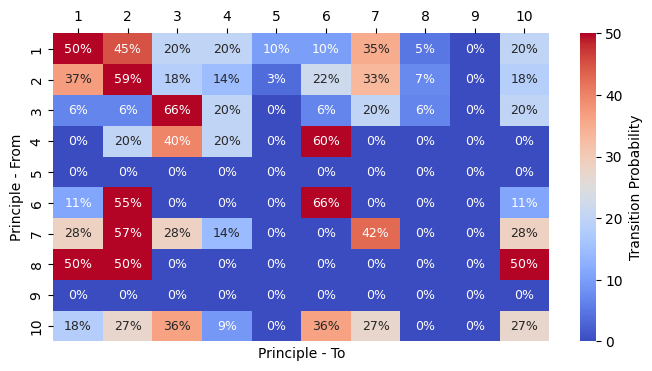

In [322]:
# make heatmap of transition matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))

annotations = (transition_matrix.divide(list_samplesize, axis=0)*100).astype(int).astype(str) + '%'
sns.heatmap(transition_matrix.divide(list_samplesize, axis=0)*100, 
            vmin=0, vmax=50,
            annot=annotations, fmt='', cmap='coolwarm', cbar_kws={'label': 'Transition Probability'}, annot_kws={"size": 9})
# plt.title('UNGC Infringement Transition Matrix, %')
plt.xlabel('Principle - To')
plt.ylabel('Principle - From')
plt.gca().xaxis.set_ticks_position('top')
plt.savefig('transition_matrix_conditioned_with_news_in_multipledates_probability.png', dpi=300)
plt.show()
